In [1]:
import os
import importlib
from tqdm import tqdm
import preprocessing
import pickle
import cv2

importlib.reload(preprocessing)
from preprocessing import *

import sunglint_correction.SUGAR
importlib.reload(sunglint_correction.SUGAR)
import sunglint_correction.SUGAR as sugar

import sunglint_correction.Hedley as Hedley
import sunglint_correction.Kutser as Kutser
import sunglint_correction.Goodman as Goodman

import sunglint_correction.validate_algo
importlib.reload(sunglint_correction.validate_algo)
import sunglint_correction.validate_algo as validate_algo

In [2]:
image_fp = "C:/Users/PAKHUIYING/Documents/image_processing/10_11_2021/11-34-17RES1280_EXP0047_GAN0030_BIT08_2EXP0000_GAN0010_RES1280_BIT08"#"C:/Users/PAKHUIYING/Documents/image_processing/10_11_2021/10-58-10RES1280_EXP0047_GAN0030_BIT08_2EXP0000_GAN0010_RES1280_BIT08"
spectrometer_fp = "C:/Users/PAKHUIYING/Documents/image_processing/10_11_2021/11_10_2021"#"C:/Users/PAKHUIYING/Documents/image_processing/10_11_2021/11_10_2021"
fp_store = r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\hyperspectral_sugar_correction" #directory to store processed files
prefix = "2021_11_10_11-34-17"
height = 58 #in meters
# if the coordinate selection is used in the GUI_platform, the gps_index_txt file will be automatically saved
gps_index_txt = "C:/Users/PAKHUIYING/Documents/image_processing/F3_processed_surveys/2021_11_10_2/gps_index_2021_11_10_11-34-17.txt"#"C:/Users/PAKHUIYING/Documents/image_processing/F3_processed_surveys/2021_11_10_1/gps_index_2021_11_10_10-58-10.txt"
slider = 1400 #in milliseconds (time delay correction)
mask_checkbox = False
classify_checkbox = False
noise_checkbox = True
sunglint_checkbox = False
radiometric_checkbox = True
corrected_indices = None
predict_checkbox = False #True

tss_lat = tss_lon = tss_measurements = None

# if the dynamic alignment is used in the GUI_platform, corrected_fp file will be automatically saved
# corrected_fp = "inputs/corrected_indices.json" #r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\test_alignment\2021_08_22\corrected_indices.json" #corrected image indices (optional)
corrected_indices = None
line_start = 0
line_stop = 1
r,g,b = 38,23,15
micasense_rgb = [28,17,7]
with open(gps_index_txt, "r") as f:
    gps_indices = f.readlines()
gps_indices = [int(i.replace('\n','')) for i in gps_indices]
gps_indices.sort()

# #------optional (can comment out)--------
# with open(corrected_fp, "r") as read_file:
#     corrected_indices = json.load(read_file)
# corrected_indices = [(i['start'],i['stop']) for i in corrected_indices]
corrected_indices = [[3734, 4174], [4869, 5478], [6093, 6946], [7714, 8766], [9533, 10684], [11387, 12852], [13496, 14857], [15793, 17179], [17969, 19375], [19899, 21248], [21992, 23408], [23963, 25309], [25910, 27033], [27701, 28729], [29468, 30212], [30625, 31030], [31594, 31817]]#[[685, 1218], [1750, 2494], [3124, 4032], [4583, 5699], [6417, 7728], [8301, 9720], [10452, 11765], [12357, 13705], [14384, 15787], [16375, 17714], [18333, 19667], [20226, 21317], [21961, 22943], [23533, 24337], [25023, 25652], [26219, 26587], [27264, 27523]]

### compute ground resolution

In [4]:
compute_ground_resolution(height)

(0.0192125, 0.38425, 19.6736)

### config file

In [4]:
config_file = {'-PROCESSED_IMAGES-':fp_store,'-PREFIX-':prefix,'-IMAGE_FOLDER_FILEPATH-':image_fp,\
                '-SPECTRO_FILEPATH-':spectrometer_fp,\
                '-HEIGHT-':height,'-GPS_INDEX_TXT-':gps_index_txt,'-SLIDER-':slider,\
                '-LINE_START-':line_start,'-LINE_END-':line_stop,'rgb_bands':[r,g,b],\
                '-MASK_CHECKBOX-':mask_checkbox,'-CLASSIFY_CHECKBOX-':classify_checkbox,\
                '-RADIOMETRIC_CHECKBOX-':radiometric_checkbox,'-NOISE_CHECKBOX-':noise_checkbox,\
                '-SUNGLINT_CHECKBOX-':sunglint_checkbox,'-PREDICT_CHECKBOX-':predict_checkbox,\
                'corrected_indices':corrected_indices}

In [79]:
gps_df = import_gps(image_fp)
unique_gps_df = get_unique_df(gps_df)
test_gps_index = gps_indices
indexes_list = gps_to_image_indices(unique_gps_df,image_fp,test_gps_index,slider)
print("Original indices: {}".format(indexes_list))
if corrected_indices is not None:
    indexes_list = corrected_indices
print("New indices: {}".format(indexes_list))
reverse_boolean_list = rev_boolean_list(unique_gps_df,test_gps_index)

gps file path:C:/Users/PAKHUIYING/Documents/image_processing/10_11_2021/11-34-17RES1280_EXP0047_GAN0030_BIT08_2EXP0000_GAN0010_RES1280_BIT08/UAV/gps_11-34-47-860.csv
Original indices: [(3705, 4145), (4840, 5454), (6068, 6921), (7688, 8741), (9503, 10659), (11359, 12824), (13468, 14827), (15766, 17154), (17931, 19344), (19922, 21278), (21955, 23371), (23942, 25287), (25932, 27061), (27672, 28698), (29499, 30235), (30653, 31062), (31529, 31796)]
New indices: [[3734, 4174], [4869, 5478], [6093, 6946], [7714, 8766], [9533, 10684], [11387, 12852], [13496, 14857], [15793, 17179], [17969, 19375], [19899, 21248], [21992, 23408], [23963, 25309], [25910, 27033], [27701, 28729], [29468, 30212], [30625, 31030], [31594, 31817]]


# Get RGB image

In [80]:
line_number = 7
start_i,end_i = indexes_list[line_number]#16500, 17000 #15700, 16000 #
test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
                    int(config_file['-HEIGHT-']),line_number,start_i,end_i,\
                    test_gps_index, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
                    reverse=reverse_boolean_list[line_number])
rgb_im = test_stitch_class.view_pseudo_colour(r,g,b) #outputs rgb
# reflectance_glint = test_stitch_class.get_stitched_reflectance() #outputs reflectance

255


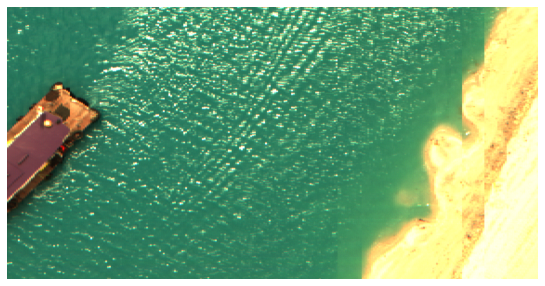

In [82]:
fig, axes = plt.subplots(1,1,figsize=(15,5))
print(rgb_im.max())
axes.imshow(rgb_im[:,6000:8000,:]) #6000:8000
axes.axis('off')
plt.show()

# Load reflectance image

In [5]:
def load_pickle(fp):
    with open(fp,'rb') as f:
        data = pickle.load(f)
    return data

def concat_pad_im(im_list,ncol):
    im_ncol = sum([im.shape[1] for im in im_list])
    im_height = im_list[0].shape[0]
    im_channel = im_list[0].shape[-1]
    pad_width = ncol - im_ncol
    pad_im = np.zeros((im_height,pad_width,im_channel))
    im_list.append(pad_im)
    corrected_images = np.concatenate(im_list,axis=1)
    return corrected_images

In [8]:
saved_reflectance_dir = r"C:\Users\PAKHUIYING\Documents\sunglint_correction\hyperspectral_results\saved_reflectance"
im_aligned_fp = [os.path.join(saved_reflectance_dir,fp) for fp in os.listdir(saved_reflectance_dir) if fp.startswith('R_T_2021')]
im_aligned = [load_pickle(fp) for fp in im_aligned_fp]

im_aligned = concat_pad_im(im_aligned,8000)
im_aligned = im_aligned[:,:8000,:]
print(im_aligned.shape)
# print(rgb_im.shape)

(1024, 8000, 61)


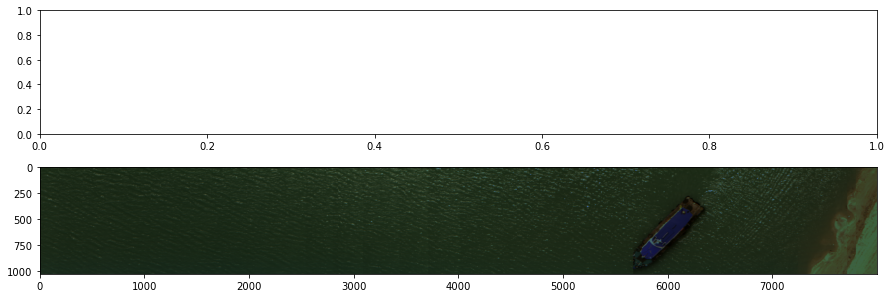

In [11]:
fig, axes = plt.subplots(2,1,figsize=(15,5))
# axes[0].imshow(rgb_im[:,:8000,:])
axes[1].imshow(np.take(im_aligned,micasense_rgb,axis=2))
plt.show()

# SUGAR correction

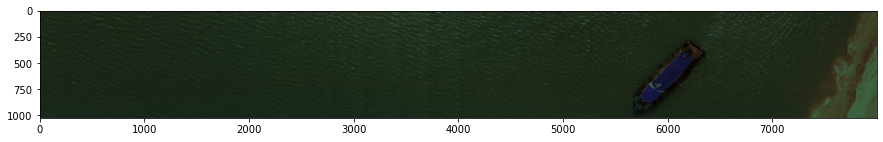

In [45]:
sgc = sugar.SUGAR(im_aligned,glint_mask_method="cdf")
sugar_corrected_bands = sgc.get_corrected_bands(plot=True)

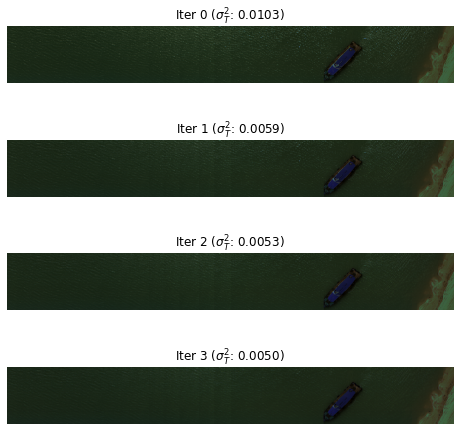

In [12]:
sugar_corrected_bands = sugar.correction_iterative(im_aligned,
                           iter=3,
                           glint_mask_method="cdf",
                           plot=True,
                           save_fp=None, 
                           termination_thresh = 20)

# Hedley

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


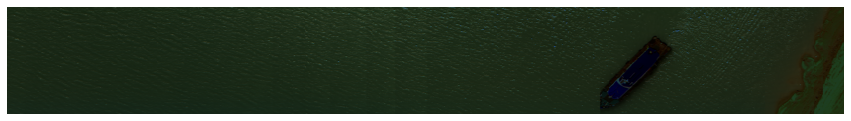

In [13]:
sgch = Hedley.Hedley(im_aligned=im_aligned,bbox = [(6400,50),(6600,300)]) #bbox = [(400,50),(600,300)]
hedley_corrected_bands = sgch.get_corrected_bands()

fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(np.stack([hedley_corrected_bands[i] for i in micasense_rgb],axis=2))
axes.axis('off')
plt.show()

# Kutser

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


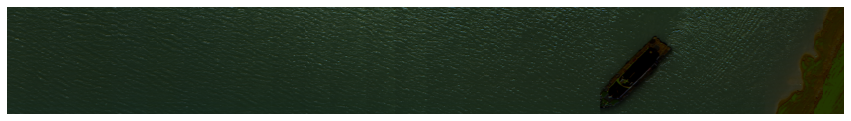

In [14]:
sgck = Kutser.Kutser(im_aligned=im_aligned,bbox = [(6400,50),(6600,300)])
kutser_corrected_bands = sgck.get_corrected_bands()

fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(np.stack([kutser_corrected_bands[i] for i in micasense_rgb],axis=2))
axes.axis('off')
plt.show()

# Goodman

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


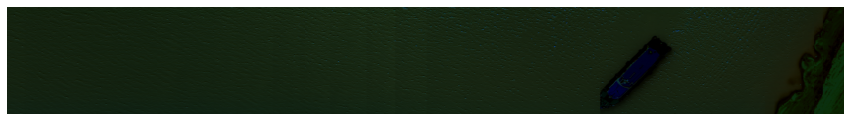

In [15]:
sgcg = Goodman.Goodman(im_aligned=im_aligned)
goodman_corrected_bands = sgcg.get_corrected_bands()

fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(np.stack([goodman_corrected_bands[i] for i in micasense_rgb],axis=2))
axes.axis('off')
plt.show()

# Compare sgc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


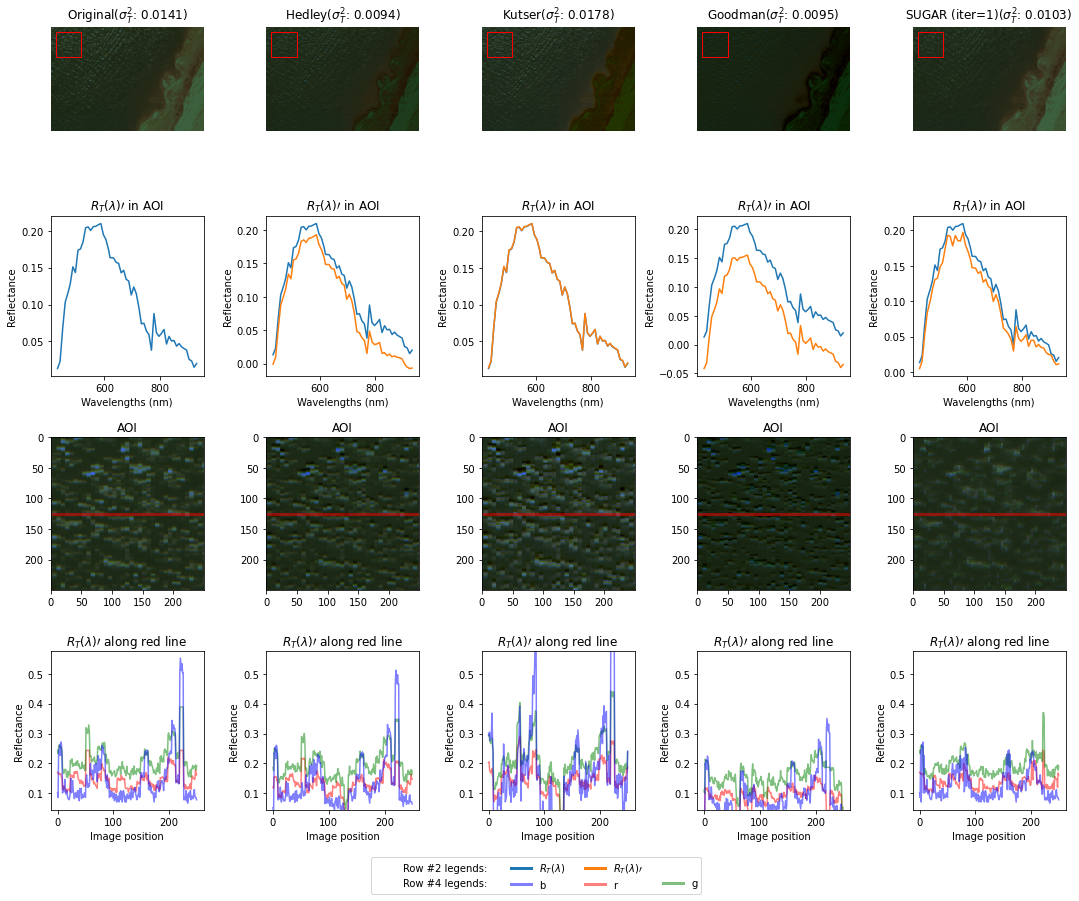

In [16]:
crop_length = 6500
og_im = im_aligned[:,crop_length:8000,:]
sugar_im = sugar_corrected_bands[1][:,crop_length:,:]
hedley_im = np.stack(hedley_corrected_bands,axis=2)[:,crop_length:,:]
kutser_im = np.stack(kutser_corrected_bands,axis=2)[:,crop_length:,:]
goodman_im = np.stack(goodman_corrected_bands,axis=2)[:,crop_length:,:]
im_list = [og_im, hedley_im, kutser_im, goodman_im,  sugar_im]
title_list = ['Original', 'Hedley' ,'Kutser','Goodman','SUGAR (iter=1)',]
# im_list = [sugar_corrected_bands[0][:,6500:,:], sugar_corrected_bands[1][:,6500:,:],]
validate_algo.compare_plots(im_list, title_list, bbox=[(50,50),(300,300)], save_dir = None)

# Plot spectral

['C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\1_R_T_2021_11_10_11-34-17_TSS_spectral_info_line7.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\2_Hedley_2021_11_10_11-34-17_TSS_spectral_info_line7.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\3_Kutser_2021_11_10_11-34-17_TSS_spectral_info_line7.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\4_Goodman_2021_11_10_11-34-17_TSS_spectral_info_line7.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\5_SUGAR_2021_11_10_11-34-17_TSS_spectral_info_line7.csv']


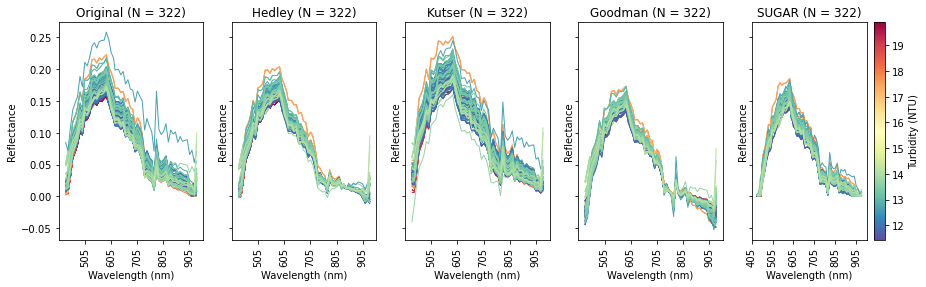

In [72]:
reflectance_dir = r"C:\Users\PAKHUIYING\Documents\sunglint_correction\hyperspectral_results\Extracted_Spectral_Information"
fp_list = [os.path.join(reflectance_dir,fp) for fp in sorted(os.listdir(reflectance_dir))]
print(fp_list)
titles = ['Original','Hedley','Kutser','Goodman','SUGAR']
VI = validate_algo.ValidateInsitu(fp_list,titles,save_dir = fp_store)
VI.plot_conc_spectral()
# rmse_list = VI.get_metrics()

['C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\insitu_validation\\1_Hedley_insitu_RMSE.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\insitu_validation\\2_Kutser_insitu_RMSE.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\insitu_validation\\3_Goodman_insitu_RMSE.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\insitu_validation\\4_SUGAR_insitu_RMSE.csv']


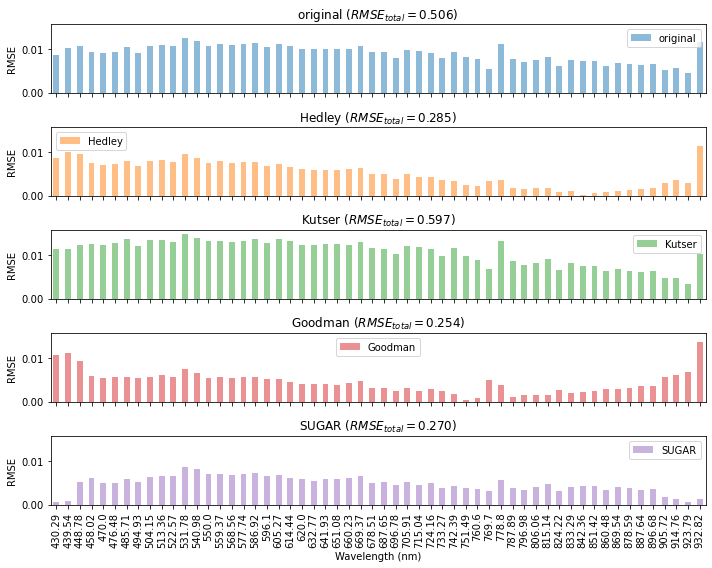

In [73]:
reflectance_dir = r"C:\Users\PAKHUIYING\Documents\sunglint_correction\hyperspectral_results\insitu_validation"
fp_list = [os.path.join(reflectance_dir,fp) for fp in sorted(os.listdir(reflectance_dir)) if fp.endswith('RMSE.csv')]
print(fp_list)
def compare_rmse(fp_list):
    df_list = [pd.read_csv(fp) for fp in fp_list]
    dfs = [df.set_index('Wavelength') for df in df_list]
    df = pd.concat(dfs, axis=1)
    n_algo = len(fp_list)
    column_idx = [0]+[i*2+1 for i in range(n_algo)]
    df = df.iloc[:,column_idx]
    rmse_list = df.sum().values
    titles = [c + r' ($RMSE_{total}=$'+ f'{rmse_list[i]:.3f})' for i,c in enumerate(df.columns)]
    df.plot.bar(subplots=True,figsize=(10,8),sharey=True,ylabel='RMSE',xlabel='Wavelength (nm)',alpha=0.5,title=titles)
    plt.tight_layout()
    return df
    
df_rmse = compare_rmse(fp_list)

# Plot WQL

In [84]:
wql_csv = r"C:\Users\PAKHUIYING\Documents\Personal\wql data\KorDSS Measurement File Export - 111021 095153.csv"
tss_df = pd.read_csv(wql_csv,engine='python')
tss_df = tss_df[tss_df['SITE']=='Flight2']
tss_lat = tss_df.iloc[:,4].tolist()
tss_lon = tss_df.iloc[:,5].tolist()
tss_measurements = tss_df.iloc[:,-2].tolist()
tss_df.head()

,DATE,TIME,SITE,DATA ID,GPS Latitude (),GPS Longitude (),Barometer (mmHg),Cond (µS/cm),Sp Cond (µS/cm),Sal (psu),nLFCond (µS/cm),TDS (mg/L),Temp (F),Resistivity (ohms-cm),Sigma-T (s t),Sigma (s),Turbidity (FNU),TSS (mg/L)
911,11/10/2021,11:33:59 am,Flight2,NaN,1.23617,103.63088,756.8,51399.3,47169.4,30.54,46701.7,30660,85.5,19.5,18.5,18.5,5.83,0
912,11/10/2021,11:34:00 am,Flight2,NaN,1.23616,103.63087,756.8,51399.2,47169.3,30.54,46701.6,30660,85.5,19.5,18.5,18.5,5.87,0
913,11/10/2021,11:34:01 am,Flight2,NaN,1.23616,103.63087,756.8,51399.5,47169.4,30.54,46701.8,30660,85.5,19.5,18.5,18.5,5.91,0
914,11/10/2021,11:34:02 am,Flight2,NaN,1.23615,103.63086,756.8,51400.0,47169.5,30.54,46701.8,30660,85.5,19.5,18.5,18.5,5.91,0
915,11/10/2021,11:34:03 am,Flight2,NaN,1.23615,103.63085,756.8,51400.4,47169.5,30.54,46701.8,30660,85.5,19.5,18.5,18.5,5.94,0


Flight angle is 60.91
Conducting georectification...
upper left:(1.238051664, 103.6293014093312)
lower right:(1.2366776693, 103.6301790906688)


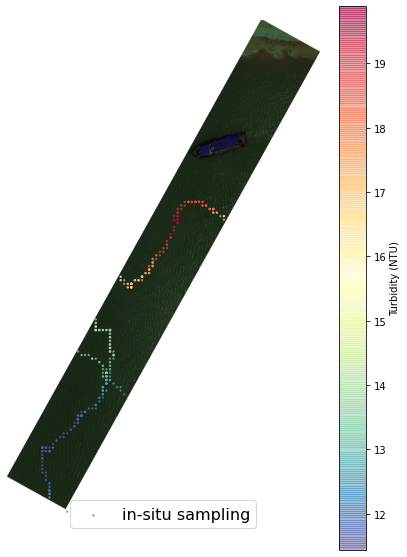

In [85]:
corrected_img = sugar_corrected_bands[1]
validate_algo.plot_insitu(test_stitch_class,np.take(corrected_img,micasense_rgb,axis=2),
                          tss_lat,tss_lon,tss_measurements,mask=None,
                          vmin=VI.clim[0],vmax=VI.clim[1],cmap=VI.cmap)

# Extract reflectance

In [ ]:
og_reflectance = {i:im_aligned[:,:,i] for i in range(im_aligned.shape[-1])}
# sugar_corrected_bands[1] is the first iteration of the sugar iterative correction
sgc_sugar_reflectance = {i:sugar_corrected_bands[1][:,:,i] for i in range(sugar_corrected_bands[1].shape[-1])}
sgc_hedley_reflectance = {i:hedley_corrected_bands[i] for i in range(len(hedley_corrected_bands))}
sgc_kutser_reflectance = {i:kutser_corrected_bands[i] for i in range(len(kutser_corrected_bands))}
sgc_goodman_reflectance = {i:goodman_corrected_bands[i] for i in range(len(goodman_corrected_bands))}

In [ ]:
# Apply mask if needed
xgb_seg_fp = r"Models\image_segmentation\xgb_segmentation.json" #for python=3.6
xgb_seg_model = load_xgb_segmentation_model(xgb_seg_fp)
mask = test_stitch_class.get_mask(xgb_seg_model,type="XGBoost")

#extraction of spectral information
# iterate with different glint corrected_reflectance
test_stitch_class.get_reflectance_from_GPS(tss_lat,tss_lon,tss_measurements,\
    radius=1, mask = mask,\
    glint_corrected_reflectance = og_reflectance,reflectance = None)

# Plot reflectance extracted from diff corrected images

['C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\1_R_T_2021_11_10_11-34-17_TSS_spectral_info_line7.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\2_Hedley_2021_11_10_11-34-17_TSS_spectral_info_line7.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\3_Kutser_2021_11_10_11-34-17_TSS_spectral_info_line7.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\4_Goodman_2021_11_10_11-34-17_TSS_spectral_info_line7.csv', 'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\hyperspectral_results\\Extracted_Spectral_Information\\5_SUGAR_2021_11_10_11-34-17_TSS_spectral_info_line7.csv']
Flight angle is 60.91
Conducting georectification...
upper left:(1.238051664, 103.6293014093312)
lower right:(1.2366776693, 103.6301790906688)


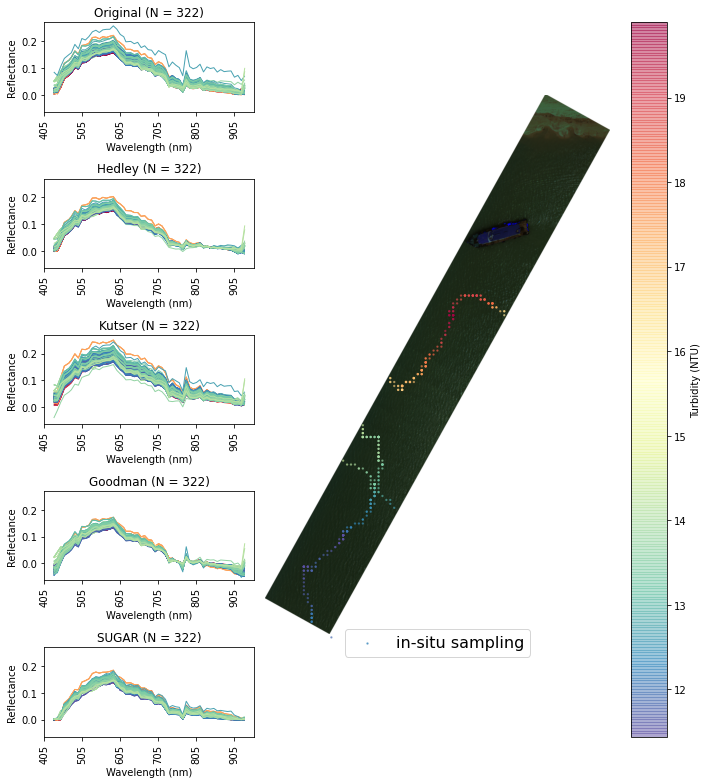

In [86]:
reflectance_dir = r"C:\Users\PAKHUIYING\Documents\sunglint_correction\hyperspectral_results\Extracted_Spectral_Information"
fp_list = [os.path.join(reflectance_dir,fp) for fp in sorted(os.listdir(reflectance_dir))]
print(fp_list)
titles = ['Original','Hedley','Kutser','Goodman','SUGAR']
VI = validate_algo.ValidateInsitu(fp_list,titles,save_dir = fp_store)
validate_algo.plot_insitu_spectral(VI,
                                test_stitch_class,np.take(corrected_img,micasense_rgb,axis=2),
                                tss_lat,tss_lon,tss_measurements,mask=None)